In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

import xarray as xr
from scipy import signal, integrate

import subroutines
import vis_eulag 

plt.style.use('latex_default.mplstyle')

In [2]:
# fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_003']
# fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_002', '/work/bd0620/b309199/translb3D/translb3D_007', '/work/bd0620/b309199/translb3D/translb3D_004']
# labels=[r'NW-SE TD ($\mathbf{\frac{\delta u}{\delta y}=0$)', 'NW-SE TD', 'N-S TD']
fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_004', '/work/bd0620/b309199/translb3D/translb3D_007']
labels=['N-S TD', 'NW-SE TD']
        
SETTINGS = vis_eulag.load_settings('settings_translb3D.txt')

CENTER_STR_X = 0.53
CENTER_STR_Y = 0.5

ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap

    ds.attrs['cp'] = np.round(ds.attrs['cp'],3) # .round(3)
    ds.attrs['cap'] = np.round(ds.attrs['cap'])
    ds.attrs['capp'] = np.round(ds.attrs['capp'])
    ds.attrs['compri'] = np.round(ds.attrs['compri'])
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    # ds['pprime']=ds['p'] # h12
    ds['pprime']=subroutines.filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?
    
    # -- Filter -- # 
    # ds.attrs['nx_avg'] = int(ds.xml*4/ds.dy00)
    # ds.attrs['nz_avg'] = int(2*np.pi*ds['ue'][0,0,0,0]/ds.bv/ds.dz00)+1
    ds.attrs['nx_avg'] = int(600*1000/ds.dx00) # 600km
    ds.attrs['nz_avg'] = int(9000/ds.dz00)+1 # 12km
    
    ds_cp = ds.copy()
    ds_list.append(ds_cp)

xfilter:  600.0
zfilter:  12.0
0
<xarray.DataArray ()>
array(0.27273158)
<xarray.DataArray ()>
array(54.58643357)
1
<xarray.DataArray ()>
array(0.16430348)
<xarray.DataArray ()>
array(58.58802154)


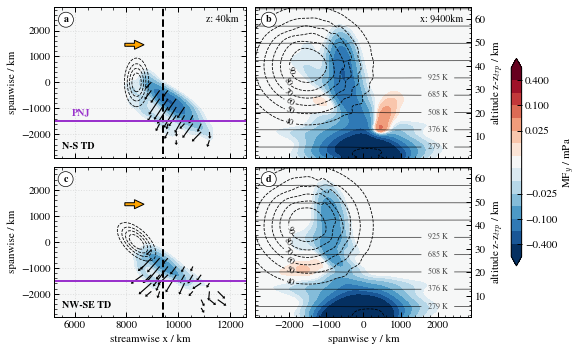

In [9]:
"Plots reference simulation for 3D simulations with TH and three time steps"
gskw = {'hspace':0.06, 'wspace':0.04, 'width_ratios': [4,4.3,0.6,0.8]}
fig, axes = plt.subplots(2,4, figsize=(9,5.7), gridspec_kw=gskw)
axes[0,2].set_axis_off()
axes[1,2].set_axis_off()
axes[0,3].set_axis_off()
axes[1,3].set_axis_off()

nz_avg = 40 # *0.25km -> 12km
# nx_avg = 33
nx_avg = 30
print('xfilter: ', nx_avg*ds.dx00/1000)
print('zfilter: ', nz_avg*ds.dz00/1000)

t = 6
zi = 133 # dz=300m 67=20km, 33=10km
zi_l = 40 # km    

y_jet = -1500
# y_jet = 0

levels_jet=[40,50,60,70,80,90]
# levels_jet=[40,60,80,100,120]

ZLIM = [1,65]
YLIM = [-2900,2900]
XLIM = [5200,12600]

lee_pos=1000 # km
x_lee_l = (-2400+50*72+lee_pos+ds.nx/2*ds.dx00/1000)
x_lee = int(x_lee_l*1000/ds.dx00)

cmap = plt.get_cmap('RdBu_r')

numb_str = ['a','b','c','d','e','f']

i=0 # rows
k=0

for ds_temp in ds_list:
    ds = ds_temp.copy()
    print(i)
    
    clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=0.8)
    norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)
    lw = 2
    
    j=0
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,zi,:,:] * (ds['u'][t,zi,:,:]-ds['ue'][t,zi,:,:])
    vw   = ds['w'][t,zi,:,:] * (ds['v'][t,zi,:,:]-ds['ve'][t,zi,:,:])
    mfx  = ds['rh0'][t,zi,:,:] * uw
    mfy  = ds['rh0'][t,zi,:,:] * vw
    efx = (ds['u'][t,zi,:,:]-ds['ue'][t,zi,:,:]) * ds['pprime'][t,zi,:,:]
    efy = (ds['v'][t,zi,:,:]-ds['ve'][t,zi,:,:]) * ds['pprime'][t,zi,:,:]
    
    mfx = subroutines.fft_gaussian_xy(mfx,nx_avg)
    mfy = subroutines.fft_gaussian_xy(mfy,nx_avg)
    efx = subroutines.fft_gaussian_xy(efx,nx_avg)
    efy = subroutines.fft_gaussian_xy(efy,nx_avg)
    
    efmax = np.max(np.sqrt(efx**2+efy**2))
    print(efmax)
    efx = efx/efmax
    efy = efy/efmax
    
    efx = np.where(np.abs(efy)>0.165,efx,np.nan) # 0.07
    efy = np.where(np.abs(efy)>0.165,efy,np.nan)
        
    contf = axes[i,j].contourf(ds.xcr[0,:], ds.ycr[:,x_lee], mfy*1000, levels=clev, cmap=cmap, norm=norm, extend='both')
    
    nn = 16
    # zbot = 60
    Q = axes[i,j].quiver(ds.xcr[0,::nn],ds.ycr[::nn,x_lee], efx[::nn, ::nn], efy[::nn,::nn], 
                  angles='xy', width=0.006, scale=7, headwidth=3,headlength=2,headaxislength=2)
    
    lw=2
    axes[i,j].vlines(x=x_lee_l,ymin=ds.ycr.min(),ymax=ds.ycr.max(), linestyles='--', lw=lw, colors='black')
    axes[i,j].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='-', lw=lw, colors='darkorchid')
    
    axes[i,j] = subroutines.format_xy_plot(ds, SETTINGS, axes[i,j], t, z=zi)
    axes[i,j].axis('scaled')
    axes[i,j].set_xlim(XLIM)
    axes[i,j].set_ylim(YLIM)
    # axes[i,j].set_title('T: ' + str(t*12) + 'h',pad=10)
    axes[i,j].set_ylabel('spanwise / km')
    
    if i!=1:
        axes[i,j].tick_params(axis="x", which='both', labelbottom=False)
    
    if i==0: 
        axes[i,j].text(0.96,0.9,'z: ' + str(zi_l) + 'km', transform=axes[i,j].transAxes, horizontalalignment='right')
        axes[i,j].text(0.095,0.28,'PNJ', weight='bold',color='darkorchid', transform=axes[i,j].transAxes)
    
    axes[i,j].grid()
    
    axes[i,j].text(0.05, 0.9, numb_str[k], transform=axes[i,j].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    axes[i,j].text(0.04,0.06, labels[i], transform=axes[i,0].transAxes, weight='bold')
    
    ### -- Vertical cross section -- ###
    j=1
    k=k+1
    
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,:,:,x_lee] * (ds['u'][t,:,:,x_lee]-ds['ue'][t,:,:,x_lee])
    vw   = ds['w'][t,:,:,x_lee] * (ds['v'][t,:,:,x_lee]-ds['ve'][t,:,:,x_lee])
    mfx  = ds['rh0'][t,:,:,x_lee] * uw
    mfy  = ds['rh0'][t,:,:,x_lee] * vw
    efy = (ds['v'][t,:,:,x_lee]-ds['ve'][t,:,:,x_lee]) * ds['pprime'][t,:,:,x_lee]
    efz = ds['w'][t,:,:,x_lee] * ds['pprime'][t,:,:,x_lee]
    
    mfx = subroutines.fft_gaussian_filter(mfx,nz_avg,nx_avg=nx_avg,usey=1)
    mfy = subroutines.fft_gaussian_filter(mfy,nz_avg,nx_avg=nx_avg,usey=1)
    efy = subroutines.fft_gaussian_filter(efy,nz_avg,nx_avg=nx_avg,usey=1)
    efz = subroutines.fft_gaussian_filter(efz,nz_avg,nx_avg=nx_avg,usey=1)
    
    # efmax = np.max(np.sqrt(efy**2+efz**2))
    zbot = 40
    nn = 16
    efmax = np.max(np.sqrt(efy[zbot:ds.nz-2*zbot:nn,:]**2+efz[zbot:ds.nz-2*zbot:nn,:]**2))
    print(efmax)
    efy = efy/efmax
    efz = efz/efmax
    
    efy = np.where(abs(efy)>0.00075,efy,np.nan)
    efz = np.where(abs(efy)>0.00075,efz,np.nan)
    
    # -- VISUALIZATION -- #    
    contf = axes[i,j].contourf(ds.ycr[:,x_lee], ds.zcr[t,:,0,x_lee], mfy*1000, levels=clev, cmap=cmap, norm=norm, extend='both')
    
    zbot1 = 102
    zbot2 = 165
    # Q = axes[i,j].quiver(ds.ycr[::nn,x_lee],ds.zcr[t,zbot1:zbot2:nn,0,x_lee], efy[zbot1:zbot2:nn, ::nn], efz[zbot1:zbot2:nn,::nn], 
    #                   angles='xy', width=0.006, scale=1/30, headwidth=3,headlength=2,headaxislength=2)
    
    cont1 = axes[i,j].contour(ds.ycr[:,0],ds.zcr[t,:,0,x_lee],ds['u'][t,:,:,x_lee].values,
                              linestyles='dashed', colors='k',  levels=levels_jet)
    
    wind_z_pos = np.linspace(15,38,6)
    wind_label = []
    for pos in wind_z_pos:
        wind_label.append((-2000,pos))
    axes[i,j].clabel(cont1, fmt='%1.0f', inline_spacing=0, inline=True, fontsize=8, manual=wind_label)
    axes[i,j] = subroutines.format_yz_plot(ds, SETTINGS, axes[i,j], t, x=x_lee)
    # axes[i,j].set_aspect(aspect=80)
    
    axes[i,j].set_ylim(ZLIM)
    axes[i,j].set_xlim(YLIM)
    axes[i,j].set_ylabel(r'altitude z-z$_{trp}$ / km')
    axes[i,j].yaxis.set_label_position("right")
    axes[i,j].tick_params(axis="y", which='both', labelleft=False, labelright=True)
    
    if i!=1:
        axes[i,j].text(0.96,0.9,'x: ' + str(int(x_lee_l)) + 'km', transform=axes[i,j].transAxes, horizontalalignment='right')
        axes[i,j].tick_params(axis="x", which='both', labelbottom=False)
    
    axes[i,j].text(0.05, 0.9, numb_str[k], transform=axes[i,j].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    k=k+1
    i+=1

    
clev_l = [-0.4,-0.1,-0.025,0.025,0.1,0.4]
cbar = fig.colorbar(contf, ax=axes[:,3], shrink=0.67, fraction=1, ticks=clev_l)
# cbar2.set_label("$\Theta'$ / K (top)  +++  E$_P$ / J kg$^{-1}$ (bottom)")
cbar.set_label("MF$_y$ / mPa")

axes[1,0].set_xlabel('streamwise x / km')
axes[1,1].set_xlabel('spanwise y / km')

axes[0,0].arrow(0.37, 0.75, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,0].transAxes, facecolor='orange', edgecolor='black')
axes[1,0].arrow(0.37, 0.75, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[1,0].transAxes, facecolor='orange', edgecolor='black')
    
# --- Save fig --- #
# fig_name = '3D-th-PNJ-south.png'
fig_name = '3D-EF-MF.png'
fig.savefig('../figures/' + fig_name, facecolor='w', edgecolor='w',
            format='png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
ds.nz

251

In [14]:
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 251, y: 480, x: 720)
Coordinates:
    xcr        (y, x) float32 0.0 20.0 40.0 ... 1.434e+04 1.436e+04 1.438e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -4.79e+03 -4.79e+03 ... 4.79e+03 4.79e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/19)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rhe        (t, z, y, x) float32 ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.838e+04 2.838e+04 ... 0.6307 0.6307
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 3.158e+04
Attributes: (12/56)
    nt:           4320
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         20000.0
    ...           ...
    capi:         3.5
    capp:         1.0
    cappi:        1.4
    compri:       11.0
    nx_avg:       30
    nz_avg:       31